Part A: Basic Prescriptive Analytics:

Step 1 & 2: Data Ingestion

In [0]:
df = spark.read.format("csv").option("header", "true").load("dbfs:/FileStore/shared_uploads/yellow_tripdata_2015_01.csv")



In [0]:
df.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       2| 2015-01-15 19:05:39|  2015-01-15 19:23:42|              1|         1.59|   -73.993896484375|40.750110626220703|        

Step 3: Initial Data Exploration

In [0]:
df.count()

12748986

In [0]:
df.columns

['VendorID',
 'tpep_pickup_datetime',
 'tpep_dropoff_datetime',
 'passenger_count',
 'trip_distance',
 'pickup_longitude',
 'pickup_latitude',
 'RateCodeID',
 'store_and_fwd_flag',
 'dropoff_longitude',
 'dropoff_latitude',
 'payment_type',
 'fare_amount',
 'extra',
 'mta_tax',
 'tip_amount',
 'tolls_amount',
 'improvement_surcharge',
 'total_amount']

In [0]:
df.summary()

DataFrame[summary: string, VendorID: string, tpep_pickup_datetime: string, tpep_dropoff_datetime: string, passenger_count: string, trip_distance: string, pickup_longitude: string, pickup_latitude: string, RateCodeID: string, store_and_fwd_flag: string, dropoff_longitude: string, dropoff_latitude: string, payment_type: string, fare_amount: string, extra: string, mta_tax: string, tip_amount: string, tolls_amount: string, improvement_surcharge: string, total_amount: string]

In [0]:
# Display the schema of the dataset
df.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [0]:
# Display basic statistics of numerical columns, such as trip distance, passenger count, and fare amount
df.select("trip_distance", "passenger_count", "fare_amount").describe().show()

+-------+------------------+------------------+------------------+
|summary|     trip_distance|   passenger_count|       fare_amount|
+-------+------------------+------------------+------------------+
|  count|          12748986|          12748986|          12748986|
|   mean|13.459129611562718|1.6814908260154964|11.905659425776989|
| stddev| 9844.094218468374|1.3379235172874737|10.302537135952232|
|    min|               .00|                 0|             -0.01|
|    max|             99.90|                 9|            999.99|
+-------+------------------+------------------+------------------+



STEP 4 : Data Cleaning

In [0]:
# Removing missing values of column "fare_amount", "trip_distance" & "passenger_count"
df_cleaned = df.na.drop(subset=["fare_amount", "trip_distance", "passenger_count"])
df_cleaned.describe().show()

+-------+------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+-------------------+---------------------+------------------+
|summary|          VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|   pickup_longitude|   pickup_latitude|        RateCodeID|store_and_fwd_flag|  dropoff_longitude|   dropoff_latitude|      payment_type|       fare_amount|              extra|           mta_tax|        tip_amount|       tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+--------------------+---------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+-------------------+------

In [0]:
from pyspark.sql.functions import col, regexp_extract
# Filter out rows with invalid data (e.g., fare_amount < 0 or trip_distance = 0)
df_cleaned = df_cleaned.filter((df_cleaned["fare_amount"] > 0) & (df_cleaned["trip_distance"] > 0) & (df_cleaned["pickup_longitude"] != 0) & (df_cleaned["pickup_latitude"] != 0) & (df_cleaned["dropoff_longitude"] != 0) & (df_cleaned["dropoff_latitude"] != 0))
valid_fare_amount_regex = "^[0-9]+(\.[0-9]{1,2})?$"
df_cleaned = df_cleaned.filter(regexp_extract(col("fare_amount").cast("string"), valid_fare_amount_regex, 0) != "")
df_cleaned.describe().show()

+-------+------------------+--------------------+---------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+------------------+------------------+-------------------+--------------------+------------------+------------------+---------------------+------------------+
|summary|          VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|   passenger_count|     trip_distance|   pickup_longitude|    pickup_latitude|        RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|      payment_type|       fare_amount|              extra|             mta_tax|        tip_amount|      tolls_amount|improvement_surcharge|      total_amount|
+-------+------------------+--------------------+---------------------+------------------+------------------+-------------------+-------------------+------------------+------------------+-------------------+------------------+----

In [0]:
from pyspark.sql.functions import col

# Convert the pickup_datetime and dropoff_datetime columns to timestamp data types
df_cleaned = df_cleaned.withColumn("pickup_datetime", col("tpep_pickup_datetime").cast("timestamp"))
df_cleaned = df_cleaned.withColumn("dropoff_datetime", col("tpep_dropoff_datetime").cast("timestamp"))

df_cleaned.show(5)

+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|   pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|  dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|    pickup_datetime|   dropoff_datetime|
+--------+--------------------+---------------------+---------------+-------------+-------------------+------------------+----------+------------------+-------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-------------------+-------------------+
|       2|

In [0]:
from pyspark.sql.functions import unix_timestamp, col

# Create new columns, such as trip duration (in minutes) and trip speed (in miles per hour)
df_cleaned = df_cleaned.withColumn("trip_duration_min", 
                                   (unix_timestamp("dropoff_datetime") - unix_timestamp("pickup_datetime")) / 60)


df_cleaned = df_cleaned.withColumn("trip_speed_mph", 
                                   col("trip_distance") / (col("trip_duration_min") / 60))

df_cleaned.select("pickup_datetime", "dropoff_datetime", "trip_duration_min", "trip_speed_mph").show(5)

+-------------------+-------------------+------------------+------------------+
|    pickup_datetime|   dropoff_datetime| trip_duration_min|    trip_speed_mph|
+-------------------+-------------------+------------------+------------------+
|2015-01-15 19:05:39|2015-01-15 19:23:42|             18.05| 5.285318559556787|
|2015-01-10 20:33:38|2015-01-10 20:53:28|19.833333333333332| 9.983193277310924|
|2015-01-10 20:33:38|2015-01-10 20:43:41|             10.05|10.746268656716417|
|2015-01-10 20:33:39|2015-01-10 20:52:58|19.316666666666666| 9.318377911993098|
|2015-01-10 20:33:39|2015-01-10 20:53:52|20.216666666666665|26.710634789777412|
+-------------------+-------------------+------------------+------------------+
only showing top 5 rows



STEP 5: Exploratory Data Analysis

In [0]:
# avg fare and avg distance group by passenger count
df_grouped_by_passenger = df_cleaned.groupBy("passenger_count").agg(
    {"fare_amount": "avg", "trip_distance": "avg"}
)

# renaming temporarily
df_grouped_by_passenger = df_grouped_by_passenger.withColumnRenamed("avg(fare_amount)", "avg_fare")\
                                                 .withColumnRenamed("avg(trip_distance)", "avg_trip_distance")

# result
df_grouped_by_passenger.show()

+---------------+------------------+------------------+
|passenger_count|          avg_fare| avg_trip_distance|
+---------------+------------------+------------------+
|              3|14.042959587975478| 3.502365063959862|
|              0|12.731226210551675| 2.901132257287401|
|              5|14.038445848844917| 3.540712301877328|
|              6| 13.88652208851831| 3.472525537512198|
|              1|13.790829828712587| 19.80164590310544|
|              4|  14.0730966302188| 3.509825008583094|
|              2|14.390632541239809|23.563276703570445|
|              9|              69.7|            15.962|
|              7|              15.6|              4.28|
|              8|              33.5| 7.263333333333333|
+---------------+------------------+------------------+



In [0]:
from pyspark.sql.functions import hour
# taking hour out of the datetime
df_with_hour = df_cleaned.withColumn("pickup_hour", hour(col("pickup_datetime")))

# group by hour
df_busiest_hours = df_with_hour.groupBy("pickup_hour").count()

df_busiest_hours = df_busiest_hours.orderBy(col("count").desc())

df_busiest_hours.show()


+-----------+------+
|pickup_hour| count|
+-----------+------+
|         19|592172|
|         18|584945|
|         20|557565|
|         21|554629|
|         22|544294|
|         17|489310|
|         23|473549|
|         14|470190|
|         15|465655|
|         13|450447|
|         12|447838|
|         11|422559|
|         16|417757|
|          9|407165|
|         10|402276|
|          8|400821|
|          0|375346|
|          7|341971|
|          1|284178|
|          2|214544|
+-----------+------+
only showing top 20 rows



In [0]:
# group by location
df_avg_fare_by_location = df_cleaned.groupBy("pickup_longitude", "pickup_latitude").agg(
    {"fare_amount": "avg"}
)

# renaming tepmorarily
df_avg_fare_by_location = df_avg_fare_by_location.withColumnRenamed("avg(fare_amount)", "avg_fare")


df_avg_fare_by_location = df_avg_fare_by_location.orderBy(col("avg_fare").desc())


df_avg_fare_by_location.show()


+-------------------+------------------+--------+
|   pickup_longitude|   pickup_latitude|avg_fare|
+-------------------+------------------+--------+
|-73.961532592773438|40.770637512207031|  4008.0|
|-73.950325012207031|40.752861022949219|   800.0|
|-73.942741394042969|40.790802001953125|   780.0|
|-73.950279235839844|40.777347564697266|  760.01|
|-73.826431274414063|40.833961486816406|   600.0|
|-73.925872802734375|40.743618011474609|   525.0|
|-73.807296752929688|40.656135559082031|   489.5|
|-73.993026733398437|40.757881164550781|  467.54|
|  -73.9478759765625|40.583606719970703|   450.0|
|-73.977920532226563|  40.7623291015625|   448.0|
|-73.974945068359375|40.760028839111328|   440.0|
|-74.000579833984375|40.722129821777344|   435.0|
|-73.781707763671875|40.644550323486328|   434.5|
|-73.789047241210937|40.647251129150391|   420.0|
| -73.98858642578125|40.768974304199219|  414.44|
|-73.873367309570313|40.774147033691406|   405.0|
|-73.973373413085937|40.746353149414063|   400.0|


STEP 6: Visualizing the Data

In [0]:
# Use display function to Visualize trip distance data
df_cleaned = df_cleaned.withColumn("trip_distance", col("trip_distance").cast("float"))
display(df_cleaned.select("trip_distance"))

trip_distance 1.59 3.3 1.8 3.0 9.0 2.2 18.2 1.1 3.1 1.1 2.38 2.83 8.33 2.37 7.13 3.6 1.25 2.11 1.15 1.53 18.06 1.76 5.19 1.38 2.23 1.56 1.57 2.92 2.9 16.4 1.73 2.25 3.53 2.01 3.37 1.35 1.18 2.05 3.05 3.06 2.6 6.17 3.72 1.1 2.63 2.22 1.79 1.14 10.2 1.48 3.14 1.14 8.98 1.5 1.26 1.56 1.5 1.1 8.79 1.39 1.64 1.53 7.48 3.0 1.51 15.2 9.96 12.63 1.2 1.18 10.89 10.39 2.96 1.18 1.62 1.56 4.96 1.0 4.3 1.1 2.9 3.5 1.2 1.3 1.9 1.0 8.1 1.0 1.6 1.6 3.2 1.0 2.2 4.2 16.3 3.12 1.9 2.6 6.8 1.3 1.4 1.2 12.6 1.08 1.58 4.39 3.37 1.53 11.4 1.46 1.25 1.3 2.05 2.32 3.4 1.56 3.1 9.5 1.1 2.2 1.1 1.4 1.6 1.6 6.9 2.9 1.6 6.4 2.0 2.4 2.6 1.3 16.3 2.3 3.5 2.7 3.7 6.4 1.1 5.6 2.2 1.0 3.5 2.3 6.4 1.7 3.5 5.7 2.0 3.2 2.1 1.1 1.8 1.4 1.5 1.6 1.8 4.9 1.2 1.1 4.7 1.0 3.7 1.5 1.5 1.2 11.8 1.5 1.2 2.4 1.7 4.9 1.3 3.8 2.3 2.3 3.9 1.3 20.1 3.0 5.0 2.1 7.5 1.7 2.0 1.1 1.4 1.9 1.2 1.4 1.0 2.2 1.6 1.4 3.4 1.1 1.8 2.5 3.8 4.5 6.08 1.34 1.81 1.96 2.33 1.22 18.36 5.24 3.54 1.85 1.26 2.47 4.0 4.97 1.62 3.12 2.04 1.16 2.36 6.13 1.3 2.23 19.7 1.12 1.02 1.34 3.38 1.36 5.4 3.1 2.0 4.7 1.0 2.0 1.1 3.1 15.5 1.6 5.3 12.3 1.91 2.46 1.67 3.2 1.88 1.33 2.88 1.54 1.13 4.77 1.7 1.29 2.2 8.75 1.28 4.54 3.26 1.14 1.6 4.6 5.1 1.39 1.32 6.76 8.62 3.8 1.65 3.16 3.52 4.65 1.48 5.56 1.69 1.69 1.26 8.86 1.96 5.78 1.71 5.53 7.07 2.3 6.0 7.2 4.0 2.1 3.04 3.67 2.35 1.68 2.1 1.2 4.2 3.27 8.88 2.7 1.29 2.49 6.57 4.1 1.52 3.6 17.46 1.56 3.0 7.47 6.88 1.8 1.6 1.5 3.3 2.2 1.0 1.6 1.7 17.5 1.6 3.2 2.3 18.0 7.0 1.2 7.2 7.0 6.9 1.1 7.5 3.2 1.1 3.5 2.8 5.0 2.4 3.7 1.1 2.1 1.2 1.0 1.3 5.2 1.0 6.8 1.1 1.8 9.3 2.9 1.3 13.4 2.0 1.3 1.7 1.7 1.4 1.8 2.3 1.3 2.3 10.2 4.5 6.9 2.8 1.5 1.4 3.6 3.2 2.1 8.0 6.9 4.3 1.4 1.0 1.6 1.9 3.1 1.0 5.3 2.4 1.0 2.1 1.3 2.4 2.2 1.0 9.3 3.8 3.3 1.1 2.1 1.5 1.0 3.3 11.04 1.9 2.65 2.2 3.53 1.83 1.56 1.99 3.19 2.24 1.5 1.65 2.39 2.28 2.66 18.1 2.74 1.85 1.33 2.35 16.76 2.38 1.5 1.68 2.26 28.66 4.01 9.3 1.22 5.73 2.88 6.43 2.25 5.69 2.48 5.05 1.2 1.16 1.7 1.12 1.87 5.82 1.47 4.7 1.26 1.9 1.87 1.9 2.36 4.5 1.88 1.95 2.4 1.6 4.86 2.29 1.3 5.2 8.5 2.5 2.9 3.3 1.44 1.29 1.16 1.0 11.8 3.3 2.1 1.2 1.7 2.2 3.9 5.3 3.0 3.6 1.0 2.6 1.1 3.4 1.15 1.85 1.25 3.55 1.01 3.09 1.72 2.46 2.23 1.84 1.35 6.41 1.31 2.43 2.87 2.21 2.0 2.8 1.7 2.8 1.5 4.77 2.18 3.29 2.21 1.0 1.2 1.3 3.6 1.4 1.2 7.7 1.26 1.49 2.18 2.53 7.31 2.71 2.27 1.86 9.9 3.2 2.68 4.32 10.59 1.71 3.61 2.09 4.26 1.39 1.46 1.01 1.89 1.37 1.69 1.12 7.86 2.1 1.25 18.06 10.3 1.7 1.27 2.1 8.7 3.1 2.4 5.4 2.1 2.7 2.2 1.2 1.1 1.9 3.2 1.5 1.0 1.7 2.7 1.5 4.41 1.0 1.0 2.62 2.9 2.04 1.19 3.0 5.6 11.21 10.8 1.2 12.2 1.2 18.41 1.5 2.13 1.31 5.78 1.29 3.54 2.12 1.88 1.89 2.72 1.47 3.45 4.66 1.47 2.26 1.28 2.04 1.68 1.59 2.5 5.49 1.51 1.1 1.25 1.15 3.8 1.3 2.1 1.54 2.9 3.9 1.6 2.5 9.38 3.5 1.8 1.2 3.3 2.1 3.2 4.6 10.16 3.09 2.29 2.5 3.3 1.25 11.26 1.94 3.9 1.66 1.22 1.3 3.87 3.23 1.03 3.24 1.73 1.32 1.3 1.6 5.1 2.1 1.4 3.9 5.0 1.9 1.4 1.6 1.2 4.5 3.5 4.3 1.4 2.66 5.46 7.46 3.57 1.96 6.03 6.41 1.16 1.97 2.62 3.09 1.44 2.21 2.64 1.44 2.5 1.3 1.8 1.1 2.9 1.0 1.7 10.23 3.4 5.3 2.5 1.6 1.2 1.2 1.6 1.8 1.8 2.0 2.9 8.2 2.55 1.5 3.47 3.85 1.52 7.77 7.81 1.24 1.58 1.13 1.11 1.09 2.3 1.21 1.38 2.57 7.52 5.2 2.8 1.2 5.6 1.1 6.4 4.9 7.6 1.5 3.5 2.0 2.1 3.8 1.4 2.1 6.2 4.1 1.7 1.4 2.8 2.4 2.1 2.7 4.6 1.8 1.1 5.6 4.8 1.6 3.0 1.3 1.1 11.5 2.0 1.4 3.8 8.0 10.5 8.3 1.8 1.0 1.5 3.1 7.8 6.3 6.4 4.1 1.5 8.7 3.3 2.4 4.3 4.9 2.7 3.9 1.3 1.6 4.4 1.8 2.6 1.2 4.2 1.2 4.5 2.6 1.1 1.7 4.8 2.1 4.75 1.84 2.73 1.55 1.52 10.13 3.36 1.01 1.8 3.41 10.07 1.37 1.12 1.53 1.94 1.78 2.44 1.24 2.16 19.9 3.2 4.2 1.2 1.5 4.3 5.7 5.6 1.3 2.5 1.5 1.1 18.4 1.1 2.6 3.3 5.1 16.5 2.5 2.6 6.9 1.6 3.0 7.9 2.2 4.9 2.12 1.2 4.3 8.5 14.5 2.0 2.0 2.1 1.7 4.9 1.8 3.1 1.17 1.54 1.8 1.5 1.1 2.91 1.34 9.96 1.18 3.58 3.5 1.9 2.4 1.1 10.7 5.3 2.8 1.2 3.0 1.0 7.4 2.5 2.8 4.9 1.7 1.9 1.6 7.1 1.7 1.9 3.0 3.1 4.2 2.8 2.3 1.8 6.3 2.9 1.2 4.0 2.0 3.0 1.4 3.3 4.6 3.2 1.4 7.5 1.5 2.0 1.3 1.3 2.5 2.6 2.2 5.8 1.8 20.0 3.6 4.4 5.3 3.3 1.1 1.4 1.9 2.1 4.2 18.3 9.2 1.5 3.6 1.6 2.2 2.3 13.2 1.7 1.4 7.8 1.8 1.0 1.7 1.3 2.6 

Databricks visualization. Run in Databricks to view.

In [0]:
from pyspark.sql.functions import hour, avg

# Calculate the average fare by hour
avg_fare_by_hour = df_cleaned.groupBy(hour(col("pickup_datetime")).alias("pickup_hour")).agg(avg("fare_amount").alias("avg_fare_amount")).orderBy("pickup_hour")

display(avg_fare_by_hour)

pickup_hour avg_fare_amount 0 14.339449867588879 1 14.121187952621286 2 14.052122035573152 3 14.635763933476857 4 16.391457380457364 5 18.026647516086477 6 15.08006388421972 7 13.734811870012384 8 13.726641643027701 9 13.74098888656934 10 13.640732780479093 11 13.562607044223432 12 13.580904523510759 13 13.927262852233472 14 14.557261107212005 15 14.632835833396 16 14.383089619084808 17 13.70193682941287 18 13.163615570694708 19 12.983364056389043 20 13.253815842099153 21 13.56233954589467 22 13.815565650181728 23 14.251047938017006

Databricks visualization. Run in Databricks to view.

STEP 7: Summary and Insights

In step 5, we can see that passenger count is clearly related to the average fare, since as the passenger count increases so does the fare, though there isn’t a notable difference in fare for passengers between 2-5. After the passenger count increases past 6, the fare seems to increase exponentially. The trip distance does not seem to have a notable correlation to passenger count or fare. However, trips with a passenger count of 1-2 and 8-9 have a much larger than usual average trip distance, with 2 passengers having the highest average trip distance. In summary, the average fair increases as the passenger count increases, and the passenger count with the highest expectable trip distance is 2 passengers.

From the second table in part 5, we can make the conclusion that the most frequent pickup hours are between 6 and 10 PM, as they are the all the top 5 pick up hours with the highest count of pick ups, and they are all over 540 thousand pick ups, unlike the rest of the hours which are all 480 thousand and smaller in pick up count.

In step 6, from the trip distance line graph we can see that the frequency of trips decreases as the distance increases, or in other words, trips of a small distance are much more frequent (which is not surprising). Trips are the most frequent between a distance of 1-2.1, miles as those distances are all much larger in count than the rest of the distances, and the count approaches 1 as the distance reaches 40 miles. 

In the Average Fare Line graph, we can see that the average fare sits between 14 and 15, with it being less than 15 except on hours 4-6, with highest fare being at 5 am, and the cheapest at 7 pm, which makes sense since 7 pm is in the range of most frequent pick up hours from the second table in part 5, we could make the conclusion that the price is lowest at that time since there is the most competition and probably more traffic, so the distance would be less and theres more options so setting a higher fare price would lower the number of potential customers. The opposite also explains the highest rate being at 5 am, since there is likely the fewest taxi’s around, they could more easily get away with charging higher fares due to less competition.

PART B: Advanced Prescriptive Analytics

1. Trip Duration:

In [0]:
from pyspark.sql.functions import col

# Calculate the trip duration by subtracting the pickup time from the drop- off time.
df_cleaned = df_cleaned.withColumn("trip_duration_min", 
                                   (col("dropoff_datetime").cast("long") - col("pickup_datetime").cast("long")) / 60)

df_cleaned.select("pickup_datetime", "dropoff_datetime", "trip_duration_min").show(5)

+-------------------+-------------------+------------------+
|    pickup_datetime|   dropoff_datetime| trip_duration_min|
+-------------------+-------------------+------------------+
|2015-01-15 19:05:39|2015-01-15 19:23:42|             18.05|
|2015-01-10 20:33:38|2015-01-10 20:53:28|19.833333333333332|
|2015-01-10 20:33:38|2015-01-10 20:43:41|             10.05|
|2015-01-10 20:33:39|2015-01-10 20:52:58|19.316666666666666|
|2015-01-10 20:33:39|2015-01-10 20:53:52|20.216666666666665|
+-------------------+-------------------+------------------+
only showing top 5 rows



2. Hour and Day:

In [0]:
from pyspark.sql.functions import hour, dayofmonth

#  Extract hour and day from the pickup_datetime to analyze hourly and daily patterns
df_cleaned = df_cleaned.withColumn("pickup_hour", hour(col("pickup_datetime")))

df_cleaned = df_cleaned.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))


df_cleaned.select("pickup_datetime", "pickup_hour", "pickup_day").show(5)

+-------------------+-----------+----------+
|    pickup_datetime|pickup_hour|pickup_day|
+-------------------+-----------+----------+
|2015-01-15 19:05:39|         19|        15|
|2015-01-10 20:33:38|         20|        10|
|2015-01-10 20:33:38|         20|        10|
|2015-01-10 20:33:39|         20|        10|
|2015-01-10 20:33:39|         20|        10|
+-------------------+-----------+----------+
only showing top 5 rows



3. Trend Over Years: Analyze how the trip duration changes over the years. Plot the
 results.

+--------------------+
|max(pickup_datetime)|
+--------------------+
| 2015-01-31 23:59:59|
+--------------------+



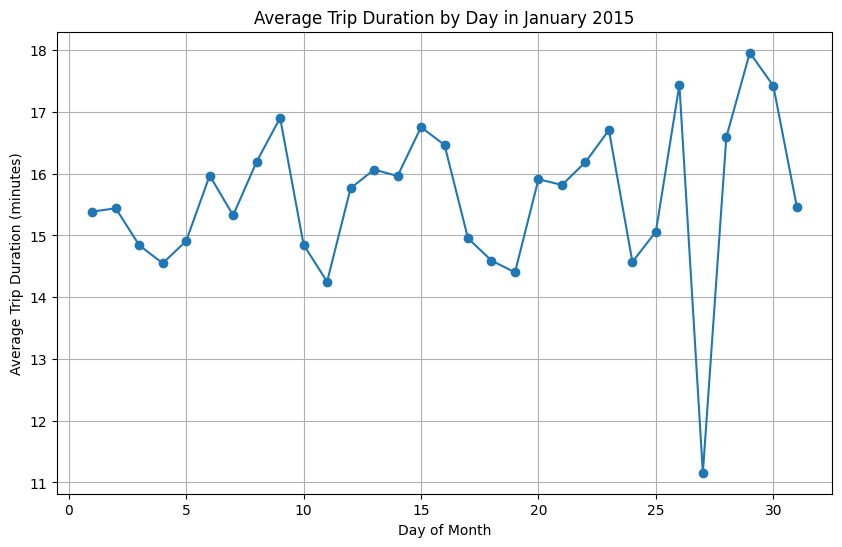

In [0]:
import matplotlib.pyplot as plt

df_cleaned.select("pickup_datetime").agg({"pickup_datetime": "min", "pickup_datetime": "max"}).show()

#since max pickup date is 31st jan 2015 , we will do how how the trip duration changes over each day of january

from pyspark.sql.functions import dayofmonth

# dayofmonth
df_cleaned = df_cleaned.withColumn("pickup_day", dayofmonth(col("pickup_datetime")))

# grouping by day
df_duration_by_day = df_cleaned.groupBy("pickup_day").agg(avg("trip_duration_min").alias("avg_trip_duration"))
df_duration_by_day = df_duration_by_day.orderBy("pickup_day")

# pandas df
df_duration_by_day_pd = df_duration_by_day.toPandas()

# plot
plt.figure(figsize=(10,6))
plt.plot(df_duration_by_day_pd["pickup_day"], df_duration_by_day_pd["avg_trip_duration"], marker='o')
plt.title("Average Trip Duration by Day in January 2015")
plt.xlabel("Day of Month")
plt.ylabel("Average Trip Duration (minutes)")
plt.grid(True)
plt.show()

4. Hourly Analysis: Check how the trip duration varies throughout the day. Plot the results


+-----------+------------------+
|pickup_hour| avg_trip_duration|
+-----------+------------------+
|          0|15.094587482838069|
|          1|14.884602197683598|
|          2|15.016721822407833|
|          3|15.335224492536504|
|          4|15.069514610764612|
|          5|15.088893829183478|
|          6|14.159144579124913|
|          7|15.208690064362195|
|          8| 16.47289180623437|
|          9|16.393476600395424|
|         10|16.045915407995178|
|         11| 15.94066714155104|
|         12|16.122697679369175|
|         13| 16.43576062592638|
|         14| 17.52447918217457|
|         15| 18.01168547529826|
|         16| 17.01756547466589|
|         17|16.594882078845707|
|         18|15.898487607096948|
|         19|14.822664755059892|
+-----------+------------------+
only showing top 20 rows



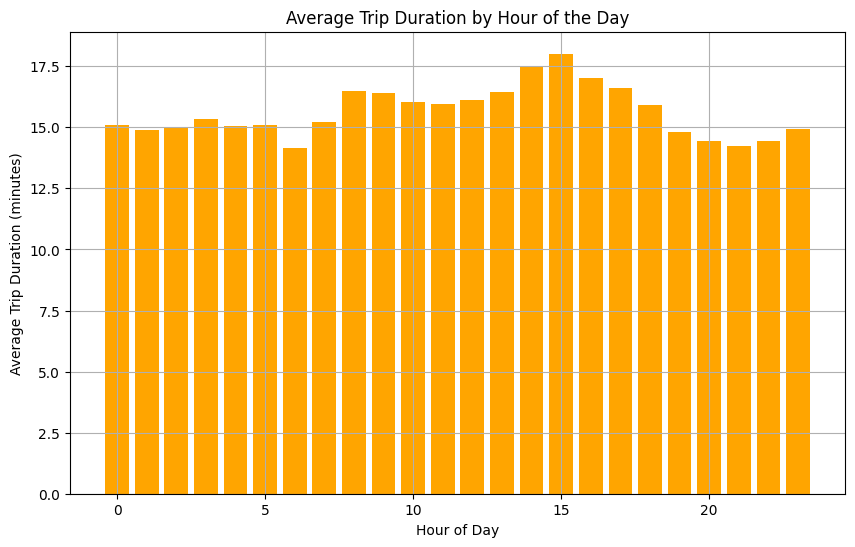

In [0]:
# Group by hour and calculate the average trip duration
df_duration_by_hour = df_cleaned.groupBy("pickup_hour").agg(avg("trip_duration_min").alias("avg_trip_duration"))

# Order the results by hour
df_duration_by_hour = df_duration_by_hour.orderBy("pickup_hour")

# Show the result
df_duration_by_hour.show()

# Convert the result to Pandas DataFrame for plotting
df_duration_by_hour_pd = df_duration_by_hour.toPandas()

# Plot the average trip duration by hour of the day
plt.figure(figsize=(10,6))
plt.bar(df_duration_by_hour_pd["pickup_hour"], df_duration_by_hour_pd["avg_trip_duration"], color='orange')
plt.title("Average Trip Duration by Hour of the Day")
plt.xlabel("Hour of Day")
plt.ylabel("Average Trip Duration (minutes)")
plt.grid(True)
plt.show()

5.Identify Hotspots:

In [0]:
from pyspark.sql.functions import count

# Create 'pickup_location' and 'dropoff_location' in new dataframe
df_hotspots = df_cleaned.select("pickup_longitude", "pickup_latitude", "dropoff_longitude", "dropoff_latitude").toPandas()
df_hotspots['pickup_location'] = df_hotspots.apply( lambda row: f"{row['pickup_longitude']}, {row['pickup_latitude']}", axis=1)
df_hotspots['dropoff_location'] = df_hotspots.apply( lambda row: f"{row['dropoff_longitude']}, {row['dropoff_latitude']}", axis=1)

# Display Pickup hotspots
pickup_hotspots = df_hotspots.groupby('pickup_location').size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)
display(pickup_hotspots)

# Display dropoff hotspots
dropoff_hotspots = df_hotspots.groupby('dropoff_location').size().reset_index(name='trip_count').sort_values(by='trip_count', ascending=False)
display(dropoff_hotspots)

pickup_location trip_count -73.948638916015625, 40.744899749755859 796 -74.186302185058594, 40.693141937255859 554 -73.986717224121094, 40.7222900390625 323 -73.915122985839844, 40.743576049804688 235 -74.003143310546875, 40.727676391601563 165 -73.921516418457031, 40.691463470458984 122 -73.988456726074219, 40.731502532958984 116 -73.978279113769531, 40.6429443359375 98 -73.942085266113281, 40.754417419433594 75 -73.921958923339844, 40.819286346435547 68 -73.990852355957031, 40.760883331298828 68 -74.006217956542969, 40.722797393798828 64 -73.870849609375, 40.773738861083984 63 -73.963775634765625, 40.760231018066406 60 -73.874443054199219, 40.774028778076172 59 -73.949897766113281, 40.787284851074219 57 -73.913444519042969, 40.827259063720703 57 -73.870887756347656, 40.773761749267578 56 -73.874496459960937, 40.774089813232422 55 -73.87451171875, 40.774070739746094 55 -73.874526977539063, 40.77410888671875 55 -73.890769958496094, 40.753505706787109 54 -73.87091064453125, 40.773788452148438 54 -73.874496459960937, 40.774078369140625 54 -73.964126586914062, 40.777107238769531 53 -73.7767333984375, 40.645378112792969 53 -73.870933532714844, 40.773780822753906 53 -73.776718139648438, 40.645378112792969 53 -73.776702880859375, 40.645378112792969 52 -73.9642333984375, 40.760147094726563 52 -73.997200012207031, 40.757160186767578 51 -73.874458312988281, 40.774051666259766 51 -73.870933532714844, 40.773761749267578 50 -73.870887756347656, 40.773788452148438 50 -73.7767333984375, 40.645408630371094 50 -73.7767333984375, 40.645431518554687 49 -73.870880126953125, 40.773731231689453 49 -73.776702880859375, 40.645393371582031 49 -73.874519348144531, 40.77410888671875 49 -73.969261169433594, 40.761268615722656 49 -73.87091064453125, 40.773761749267578 49 -73.874473571777344, 40.774078369140625 48 -73.870933532714844, 40.773811340332031 48 -73.874519348144531, 40.774101257324219 48 -73.870872497558594, 40.773761749267578 48 -73.87445068359375, 40.774040222167969 48 -73.998634338378906, 40.73486328125 47 -73.87451171875, 40.774078369140625 47 -73.7767333984375, 40.645416259765625 47 -73.776710510253906, 40.645393371582031 47 -73.870887756347656, 40.773738861083984 47 -73.532493591308594, 40.764877319335938 47 -73.874443054199219, 40.774021148681641 47 -73.87451171875, 40.774093627929688 47 -73.87091064453125, 40.773750305175781 47 -73.7767333984375, 40.645393371582031 47 -73.874488830566406, 40.774070739746094 46 -73.776702880859375, 40.645351409912109 46 -73.870918273925781, 40.773788452148438 46 -74.002555847167969, 40.723136901855469 46 -73.776718139648438, 40.645401000976563 46 -73.874473571777344, 40.774051666259766 46 -73.776702880859375, 40.645370483398437 45 -73.870841979980469, 40.773700714111328 45 -73.9736328125, 40.743892669677734 45 -74.004486083984375, 40.730682373046875 45 -73.870857238769531, 40.773738861083984 45 -73.928688049316406, 40.681427001953125 45 -73.87091064453125, 40.773769378662109 45 -73.776679992675781, 40.645370483398437 44 -73.874473571777344, 40.774070739746094 44 -73.776771545410156, 40.645408630371094 44 -73.870872497558594, 40.773719787597656 44 -73.776718139648438, 40.645370483398437 44 -73.874496459960937, 40.774070739746094 44 -73.870933532714844, 40.773750305175781 44 -73.874526977539063, 40.774101257324219 44 -73.776710510253906, 40.645378112792969 44 -73.776718139648438, 40.645408630371094 44 -73.981964111328125, 40.683570861816406 44 -73.874458312988281, 40.774040222167969 44 -73.870872497558594, 40.773738861083984 43 -73.874542236328125, 40.774101257324219 43 -73.776741027832031, 40.645408630371094 43 -73.532608032226562, 40.764827728271484 43 -73.776718139648438, 40.645351409912109 43 -73.7767333984375, 40.645351409912109 43 -73.965751647949219, 40.761978149414063 43 -73.980911254882812, 40.683185577392578 43 -73.776710510253906, 40.645370483398437 43 -73.870933532714844, 40.773788452148438 42 -73.776687622070313, 40.645351409912109 42 -73.953788757324219, 40.821933746337891 42 -73.874412536621

Databricks visualization. Run in Databricks to view.

dropoff_location trip_count -73.948638916015625, 40.744899749755859 796 -74.186302185058594, 40.693141937255859 554 -73.986717224121094, 40.7222900390625 322 -73.915122985839844, 40.743576049804688 234 -74.003143310546875, 40.727676391601563 165 -73.921516418457031, 40.691463470458984 122 -73.988456726074219, 40.731502532958984 115 -73.978279113769531, 40.6429443359375 98 -73.942085266113281, 40.754417419433594 74 -73.921958923339844, 40.819286346435547 68 -73.990852355957031, 40.760883331298828 68 -74.006217956542969, 40.722797393798828 66 -73.963775634765625, 40.760231018066406 60 -73.949897766113281, 40.787284851074219 58 -73.913444519042969, 40.827259063720703 57 -73.890769958496094, 40.753505706787109 54 -73.964126586914062, 40.777107238769531 53 -73.9642333984375, 40.760147094726563 53 -73.997200012207031, 40.757160186767578 48 -73.969261169433594, 40.761268615722656 48 -73.532493591308594, 40.764877319335938 47 -73.998634338378906, 40.73486328125 47 -73.9736328125, 40.743892669677734 46 -74.002555847167969, 40.723136901855469 45 -74.004486083984375, 40.730682373046875 45 -73.928688049316406, 40.681427001953125 45 -73.981964111328125, 40.683570861816406 44 -73.980911254882812, 40.683185577392578 43 -73.532608032226562, 40.764827728271484 43 -73.965751647949219, 40.761978149414063 42 -73.953788757324219, 40.821933746337891 42 -73.928817749023438, 40.812179565429688 40 -74.095367431640625, 40.717048645019531 39 -73.869987487792969, 40.772281646728516 38 -73.971359252929688, 40.78179931640625 38 -73.944618225097656, 40.678302764892578 38 -73.789802551269531, 40.647018432617188 37 -73.980278015136719, 40.682819366455078 37 -73.964958190917969, 40.760009765625 37 -73.91619873046875, 40.77996826171875 36 -73.933372497558594, 40.737159729003906 36 -74.001800537109375, 40.746681213378906 36 -74.008293151855469, 40.7490234375 35 -73.973052978515625, 40.795406341552734 34 -73.947792053222656, 40.783462524414063 34 -73.956787109375, 40.714744567871094 33 -73.949905395507813, 40.784252166748047 33 -73.980796813964844, 40.683071136474609 31 -73.984390258789063, 40.754558563232422 31 -73.990371704101563, 40.734943389892578 31 -73.959213256835938, 40.777332305908203 31 -73.972076416015625, 40.632926940917969 31 -73.991279602050781, 40.700977325439453 31 -73.976158142089844, 40.643932342529297 31 -73.950897216796875, 40.786182403564453 30 -73.980552673339844, 40.683120727539063 30 -73.994514465332031, 40.750656127929687 30 -73.955101013183594, 40.774219512939453 30 -73.995048522949219, 40.7618408203125 29 -73.980644226074219, 40.750949859619141 29 -73.967704772949219, 40.792579650878906 29 -73.871757507324219, 40.774166107177734 28 -73.964653015136719, 40.770328521728516 28 -73.957954406738281, 40.783138275146484 28 -73.986824035644531, 40.74835205078125 28 -73.973312377929688, 40.795024871826172 28 -73.957038879394531, 40.774848937988281 28 -73.884483337402344, 40.746196746826172 28 -73.992408752441406, 40.758537292480469 27 -73.782341003417969, 40.644638061523438 27 -73.909912109375, 40.8271484375 27 -73.861686706542969, 40.768348693847656 27 -73.937850952148438, 40.756942749023437 26 -73.7938232421875, 40.656757354736328 26 -73.916267395019531, 40.780220031738281 26 -73.946403503417969, 40.749919891357422 26 -74.004859924316406, 40.705390930175781 26 -73.93389892578125, 40.752426147460938 26 -73.975479125976562, 40.749320983886719 26 -74.052902221679688, 40.727561950683594 26 -74.002784729003906, 40.708473205566406 26 -73.869361877441406, 40.772731781005859 25 -73.861778259277344, 40.768398284912109 25 -74.00274658203125, 40.7606201171875 24 -73.954078674316406, 40.790214538574219 24 -73.9759521484375, 40.644191741943359 24 -73.861808776855469, 40.768428802490234 24 -73.968696594238281, 40.791770935058594 24 -73.861747741699219, 40.768398284912109 24 -73.976295471191406, 40.744270324707031 24 -74.000617980957031, 40.761814117431641 24 -73.865028381347656, 40.770511627197266 24 -73.94793701171875, 40.782138824462891 23 -73.97243499755

Databricks visualization. Run in Databricks to view.

6. Average Fair by Location:

In [0]:
import pandas as pd
# Create 'pickup_location'
df_locations = df_cleaned.select("pickup_longitude", "pickup_latitude", "fare_amount").toPandas()
df_locations['pickup_location'] = df_locations.apply(lambda row: f"({row['pickup_longitude']}, {row['pickup_latitude']})", axis=1)
df_locations['fare_amount'] = pd.to_numeric(df_locations['fare_amount'], errors='coerce')

# Find average fare based on pickup location
avg_fare_by_location = df_locations.groupby('pickup_location')['fare_amount'].mean().reset_index()
avg_fare_by_location.columns = ['Pickup Location', 'Average Fare Amount']

# Display results
display(avg_fare_by_location)

Pickup Location Average Fare Amount (-1.3151819705963135, 40.746593475341797) 16.5 (-105.75955963134766, 56.952297210693359) 9.0 (-108.16533660888672, 42.396537780761719) 12.0 (-119.31465148925781, 59.504623413085937) 17.5 (-35.433998107910156, 82.498008728027344) 7.5 (-49.201419830322266, 29.122262954711914) 12.0 (-51.341644287109375, 55.782413482666016) 8.0 (-54.400753021240234, 34.220844268798828) 9.5 (-54.851154327392578, 30.487075805664063) 8.0 (-55.062873840332031, 53.308731079101563) 10.5 (-56.482376098632813, 27.395221710205078) 18.0 (-56.652030944824219, 40.207103729248047) 9.5 (-57.388072967529297, 42.306449890136719) 21.5 (-59.480930328369141, 29.815818786621094) 9.5 (-60.082065582275391, 44.199745178222656) 18.7 (-60.826602935791016, 38.177963256835938) 7.5 (-62.065692901611328, 50.197074890136719) 13.0 (-62.764919281005859, 49.219017028808594) 15.0 (-63.138957977294922, 42.495735168457031) 8.0 (-63.206707000732422, 55.708854675292969) 8.5 (-64.10455322265625, 31.357736587524414) 11.0 (-64.482009887695313, 31.516336441040039) 20.5 (-64.501556396484375, 48.393726348876953) 10.0 (-64.652938842773437, 39.332099914550781) 9.0 (-64.762451171875, 53.784027099609375) 15.5 (-64.999931335449219, 38.338123321533203) 15.0 (-65.192939758300781, 36.735309600830078) 12.5 (-65.540863037109375, 47.730579376220703) 6.5 (-65.573684692382813, 36.761760711669922) 16.0 (-65.76092529296875, 38.609035491943359) 18.0 (-65.930099487304687, 37.511634826660156) 10.0 (-65.962066650390625, 38.484046936035156) 10.0 (-65.968635559082031, 49.389045715332031) 21.5 (-66.021743774414062, 42.126491546630859) 15.5 (-66.902290344238281, 43.489101409912109) 6.5 (-66.912178039550781, 42.191368103027344) 6.5 (-67.664093017578125, 39.762275695800781) 9.0 (-67.847030639648438, 43.2823486328125) 13.0 (-68.054466247558594, 42.471157073974609) 11.5 (-68.055030822753906, 39.917171478271484) 37.0 (-68.140068054199219, 39.670291900634766) 6.5 (-68.416069030761719, 43.759212493896484) 8.2 (-68.427413940429687, 29.55451774597168) 6.5 (-68.488082885742188, 43.697338104248047) 9.5 (-68.503852844238281, 51.402141571044922) 8.0 (-68.562568664550781, 45.445487976074219) 10.0 (-68.570846557617188, 40.854808807373047) 25.2 (-68.885986328125, 42.154125213623047) 22.5 (-68.963592529296875, 42.538360595703125) 5.2 (-69.088478088378906, 42.753574371337891) 73.5 (-69.291862487792969, 31.199140548706055) 14.0 (-69.379501342773438, 34.026840209960938) 11.5 (-69.4024658203125, 44.958602905273437) 9.0 (-69.407920837402344, 39.505001068115234) 17.5 (-69.456962585449219, 36.766082763671875) 7.2 (-69.541244506835938, 40.299201965332031) 8.0 (-69.584403991699219, 29.775070190429688) 8.0 (-69.601593017578125, 29.874656677246094) 13.0 (-69.665802001953125, 29.524003982543945) 24.25 (-69.7886962890625, 37.016674041748047) 13.0 (-69.797660827636719, 43.698749542236328) 20.5 (-69.845001220703125, 35.990798950195313) 11.5 (-70.050254821777344, 35.032516479492187) 8.0 (-70.075645446777344, 37.427265167236328) 7.5 (-70.47515869140625, 38.723098754882812) 21.0 (-70.914047241210938, 41.174552917480469) 16.5 (-70.996025085449219, 38.29534912109375) 11.0 (-71.019020080566406, 57.470916748046875) 8.0 (-71.06060791015625, 35.874393463134766) 15.0 (-71.3516845703125, 53.152587890625) 22.0 (-71.47021484375, 38.736862182617188) 52.0 (-71.478141784667969, 57.385520935058594) 7.0 (-71.750335693359375, 42.294155120849609) 6.0 (-72.016937255859375, 39.172218322753906) 8.166666666666666 (-72.019554138183594, 42.349849700927734) 20.2 (-72.093727111816406, 34.532371520996094) 12.0 (-72.093879699707031, 46.177249908447266) 5.7 (-72.319694519042969, 43.898353576660156) 5.5 (-72.320762634277344, 41.513622283935547) 8.5 (-72.387260437011719, 38.315090179443359) 8.5 (-72.412155151367188, 36.935146331787109) 19.5 (-72.412643432617188, 48.662410736083984) 9.0 (-72.449424743652344, 40.115901947021484) 14.571428571428571 (-72.569664001464844, 40.980968475341797) 9.0 (-72.588088989257813, 40.160064697265625) 12.0 (-72

Databricks visualization. Run in Databricks to view.

7. Correlation Analysis

Correlation between trip duration and trip distance: 1.5306018579757404e-05
Correlation between trip duration and fare amount: 0.011440083866136857


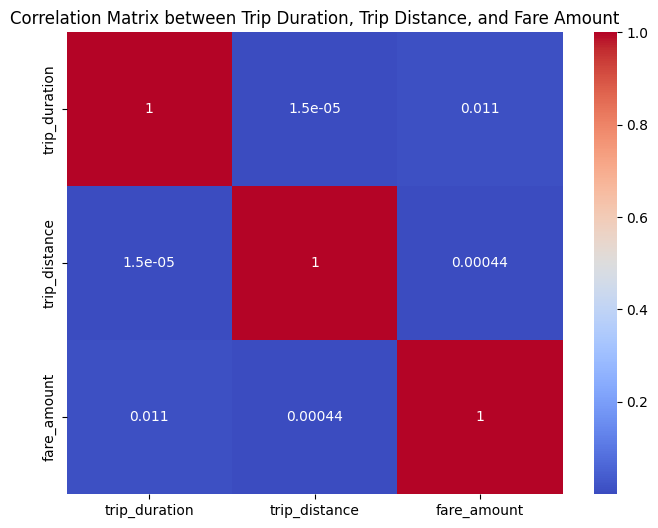

In [0]:
# Calculate trip duration in minutes
df = df.withColumn('trip_duration', 
                   ((col('tpep_dropoff_datetime').cast('long') - col('tpep_pickup_datetime').cast('long')) / 60).cast('double'))

# Convert columns to double type for consistency
df = df.withColumn('trip_distance', col('trip_distance').cast('double'))
df = df.withColumn('fare_amount', col('fare_amount').cast('double'))

# Filter out rows with null values in key columns
df = df.filter((col('trip_duration').isNotNull()) & 
               (col('trip_distance').isNotNull()) & 
               (col('fare_amount').isNotNull()))

# Calculate correlations
correlation = df.stat.corr('trip_duration', 'trip_distance')
fare_correlation = df.stat.corr('trip_duration', 'fare_amount')

# Print correlation results
print(f"Correlation between trip duration and trip distance: {correlation}")
print(f"Correlation between trip duration and fare amount: {fare_correlation}")

# Create a pandas DataFrame and correlation matrix
corr_df = df.select('trip_duration', 'trip_distance', 'fare_amount').toPandas()
corr_matrix = corr_df.corr()

# Plot the correlation matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix between Trip Duration, Trip Distance, and Fare Amount')
plt.show()


The trip duration and fare amount have a correlation (since how long the trip takes will influence the fare). The fare amount also has a correlation to trip distance (which also makes sense for the same reason. Trip distance and trip duration have the least correlation (which is likely influenced by traffic).

8. Examine taxi demand

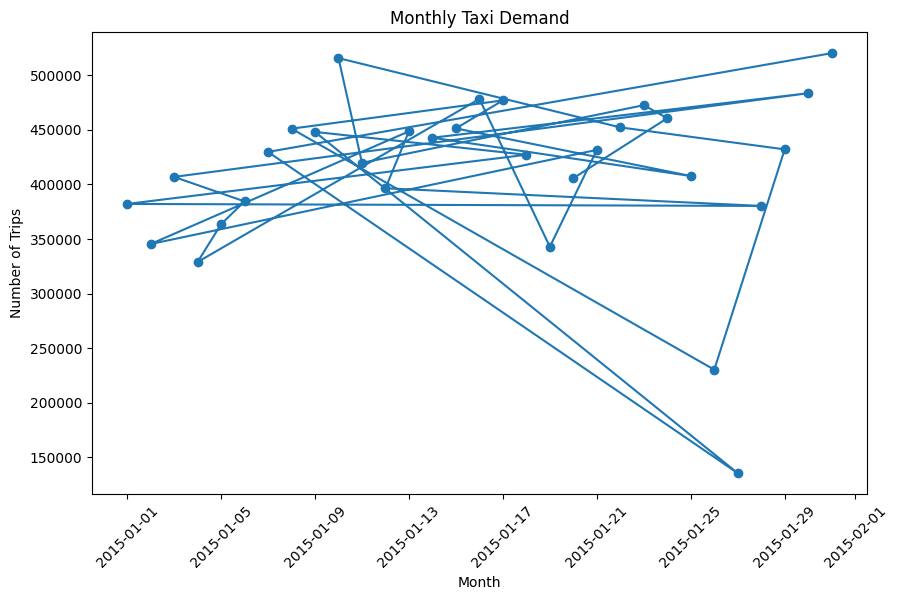

In [0]:
# Cast pickup datetime column to timestamp type
df = df.withColumn('tpep_pickup_datetime', df['tpep_pickup_datetime'].cast('timestamp'))

# Extract the pickup month (date) from the pickup datetime
df = df.withColumn('pickup_month', df['tpep_pickup_datetime'].cast('date'))

# Group by pickup month and count the number of trips per month
monthly_trips = df.groupby('pickup_month').count()

# Convert the grouped data to pandas for plotting
plt.figure(figsize=(10, 6))
monthly_trips_df = monthly_trips.toPandas()

# Plot the number of trips by month
plt.plot(monthly_trips_df['pickup_month'], monthly_trips_df['count'], marker='o')
plt.title('Monthly Taxi Demand')
plt.xlabel('Month')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.show()

Taxi demand appears to be at its highest near the middle of the month (days 14-18), and in the last day of the month, and seems low at start of the month (days 1-5), and at its lowest on the 27th.